In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
import omicverse as ov
from omicverse.utils import mde
import scanpy as sc
import scvelo as scv
ov.utils.ov_plot_set()

In [ ]:
!cd data; wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171993/suppl/GSE171993_filtered_feature_bc_matrix.h5
!cd data; wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171993/suppl/GSE171993_metadata.csv.gz

--2023-09-30 18:11:07--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171993/suppl/GSE171993_filtered_feature_bc_matrix.h5
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 165.112.9.229
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... 

In [ ]:
adata=sc.read_10x_h5('data/GSE171993_filtered_feature_bc_matrix.h5')
adata

In [ ]:
obs_data=ov.read('data/GSE171993_metadata.csv.gz',index_col=0)
#obs_data.head()

In [ ]:
both_cell_idx=list(set(adata.obs_names) & set(obs_data.index))
len(both_cell_idx)

In [ ]:
adata=adata[both_cell_idx]
adata

In [ ]:
adata.obs=obs_data.loc[both_cell_idx]
adata

In [ ]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [ ]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)
adata

In [ ]:
adata1=adata[:,adata.var['highly_variable_features']==True].copy()
adata1

In [ ]:
ov.pp.scale(adata1)
ov.pp.pca(adata1,layer='scaled',n_pcs=50)

In [ ]:
sc.pp.neighbors(adata1, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
adata1.obsm["X_mde"] = ov.utils.mde(adata1.obsm["scaled|original|X_pca"])
adata1

In [ ]:
ov.utils.embedding(adata1,
                basis='X_mde',frameon='small',
                color=['timepoint','celltype'],
                show=False,ncols=2)

In [ ]:
adata.obsm=adata1.obsm.copy()
adata.obsp=adata1.obsp.copy()

In [ ]:
adata.X=adata.layers['counts'].copy()
adata

In [ ]:
adata.write_h5ad('data/liver_anno.h5ad',compression='gzip')

In [ ]:
adata_hpc=adata[adata.obs['celltype'].isin(['Pro-B', 'Large Pre-B', 'Small Pre-B', 'B',
                                                    'HPC','GMP','iNP','imNP','mNP',
                                                    'Basophil','Monocyte','cDC1','cDC2','pDC','aDC',
                                                    'Kupffer','Pro-erythroblast','Erythroblast',
                                                    'erythrocyte']
                                          )]
adata_hpc.obsm["X_mde_hpc"] = ov.utils.mde(adata_hpc.obsm["scaled|original|X_pca"])
sc.pp.neighbors(adata_hpc, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')
adata_hpc


In [ ]:
ov.utils.embedding(adata_hpc,
                basis='X_mde_hpc',frameon='small',
                color=['timepoint','celltype'],
                show=False,ncols=2)

In [ ]:
adata_hpc.write_h5ad('data/liver_hpc_anno.h5ad',compression='gzip')

In [3]:
adata_hpc=sc.read('data/liver_hpc_anno.h5ad',compression='gzip')

In [4]:
adata_hpc.X.max()

8615.0

In [5]:
import numpy as np
import pandas as pd
bulk=pd.read_csv('data/GSE58827_FPKM.txt.gz',index_col=0,sep='\t',header=1)
#bulk=ov.bulk.Matrix_ID_mapping(bulk,'genesets/pair_GRCm39.tsv')
bulk.head()

,D-2,D-2.1,D-2.2,D0,D0,D0.1,D1,D1.1,D1.2,D3,...,D25.2,D30,D30.1,D30.2,D45,D45.1,D45.2,D60,D60.1,D60.2
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
0610007C21Rik,18.48160,28.29490,24.61790,42.37870,33.34830,41.60700,57.6597,63.41470,64.04740,37.80720,...,51.30120,63.78840,45.19360,54.98550,45.92580,48.11880,56.38370,50.75280,48.55550,54.92510
0610007L01Rik,14.19070,12.70240,11.80150,12.56880,8.31761,9.62451,16.7531,13.15530,13.00190,12.49530,...,7.70820,6.89976,10.68430,11.19820,7.71271,7.78097,6.92665,8.95075,8.89625,7.78528
0610007P08Rik,1.71090,0.83838,0.76108,0.36203,0.50162,0.39988,1.0015,0.64103,0.59142,1.03540,...,0.37039,0.17313,0.62976,0.34409,0.34740,0.27636,0.23581,0.56421,0.71718,0.46741
0610007P14Rik,41.85590,48.17630,45.65490,15.94520,41.84570,49.94160,32.0791,41.87910,30.60340,51.52930,...,49.23110,28.13490,35.72540,44.27430,32.64790,43.05270,31.75820,33.15400,42.72720,49.06030
0610007P22Rik,6.69505,9.71821,8.49785,9.61188,6.70561,7.89604,8.6380,10.05780,11.05510,6.81731,...,6.45745,8.29360,8.04557,7.57137,5.29742,6.44480,7.82238,5.25578,6.53128,7.03206


In [6]:
#raw_columns=bulk.columns.tolist()
#new_columns=[i+'-'+j for i, j in zip(bulk.iloc[0],raw_columns)]

In [7]:
bulktb=ov.bulk2single.BulkTrajBlend(bulk_seq=bulk,single_seq=adata_hpc,
                                    bulk_group=bulk.columns.tolist(),
                                    celltype_key='celltype',)
#bulktb.bulk_preprocess_lazy()
#bulktb.single_preprocess_lazy()

In [54]:
bulktb.vae_configure(cell_target_num=200)

......random select 5000 single cells
......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


In [56]:
bulktb.vae_model.single_data

AnnData object with n_obs × n_vars = 5000 × 18648
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lib_ID', 'lib', 'percent.mt', 'timepoint', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'timepoint_colors'
    obsm: 'X_mde', 'X_mde_hpc', 'scaled|original|X_pca'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
features=bulktb.vae_model.input_data['input_sc_data'].T
labels=bulktb.vae_model.input_data['input_sc_meta']['Cell_type'].astype('str')

# 将类别字符串映射为数字编码
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
labels_encoded = labels.map(label_mapping)

# 转换为 PyTorch 张量
features_tensor = torch.Tensor(features.values)
labels_tensor = torch.LongTensor(labels_encoded.values)  # 使用 LongTensor 存储整数标签


In [10]:
# 创建 DataLoader（如果需要）
# DataLoader 可以帮助你批量加载数据，方便训练
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [11]:
n_epochs=200
batch_size=64
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
n_classes=len(list(set(labels)))  # 类别数量
img_size=features.shape[1]
channels=1
sample_interval=400
n_features=features.shape[1]

In [12]:
cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm1d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [89]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes,n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, n_features),
            #nn.Sigmoid()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        #img = img.view(img.size(0), *img_shape)
        return img

In [90]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Linear(512, 1),
        )
        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(512, n_classes), nn.Softmax())

    def forward(self, img):
        # Concatenate label embedding and image to produce input
        #d_in = torch.cat((img, self.label_embedding(labels)), -1)
        out=self.model(img)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        return validity,label

In [91]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

In [92]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (label_embedding): Embedding(18, 18)
  (model): Sequential(
    (0): Linear(in_features=13849, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (aux_layer): Sequential(
    (0): Linear(in_features=512, out_features=18, bias=True)
    (1): Softmax(dim=None)
  )
)

In [93]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [94]:

# ----------
#  Training
# ----------
from tqdm import trange,tqdm

n_epochs=1000
latent_dim=100

bar = tqdm(range(n_epochs))
d_loss_li=[]
g_loss_li=[]
d_acc_li=[]

d_r_acc_li=[]
d_f_acc_li=[]

for epoch in bar:
    for i, (imgs, labels) in enumerate(data_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        real_pred=real_aux.data.cpu().numpy()
        fake_pred=fake_aux.data.cpu().numpy()
        real_gt=labels.data.cpu().numpy()
        fake_gt=gen_labels.data.cpu().numpy()
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)
        real_acc=np.mean(np.argmax(real_pred, axis=1) == real_gt)
        fake_acc=np.mean(np.argmax(fake_pred, axis=1) == fake_gt)

        d_loss.backward()
        optimizer_D.step()


    bar.set_description(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%, real_acc: %d%%, fake_acc: %d%%] [G loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), d_loss.item(), 100 * d_acc, 100*real_acc,100*fake_acc,g_loss.item())
        )
    d_loss_li.append(d_loss.item())
    g_loss_li.append(g_loss.item())
    d_acc_li.append(100*d_acc)
    d_r_acc_li.append(100*real_acc)
    d_f_acc_li.append(100*fake_acc)

[Epoch 242/3000] [Batch 78/79] [D loss: 1.108809, acc: 100%, real_acc: 100%, fake_acc: 100%] [G loss: 2.796869]:   8%|▊         | 243/3000 [02:34<29:09,  1.58it/s]


KeyboardInterrupt: 

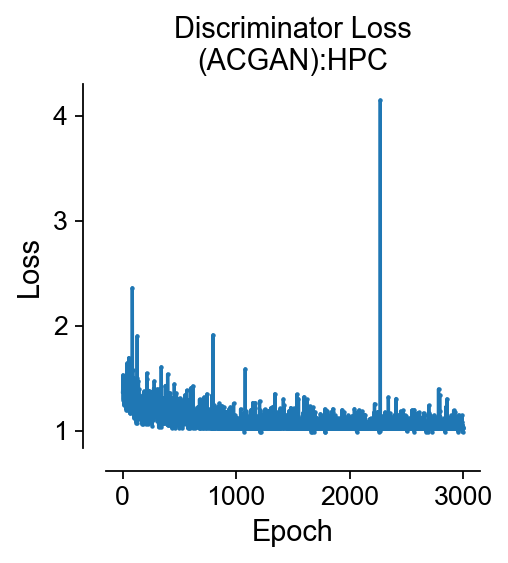

In [47]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(range(len(d_loss_li)),d_loss_li,s=1)
ax.plot(range(len(d_loss_li)),d_loss_li)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Discriminator Loss\n(ACGAN):HPC',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_d_acgan_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_d_acgan_hpc.pdf',dpi=300,bbox_inches='tight')


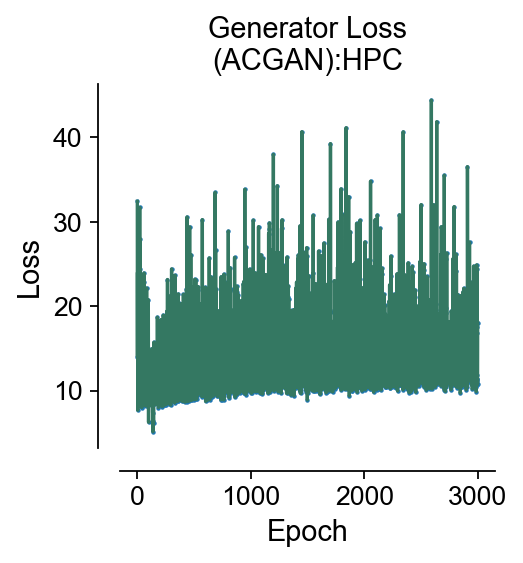

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(range(len(g_loss_li)),g_loss_li,s=1)
ax.plot(range(len(g_loss_li)),g_loss_li,color=ov.utils.blue_color[0])

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Generator Loss\n(ACGAN):HPC',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_g_acgan_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_g_acgan_hpc.pdf',dpi=300,bbox_inches='tight')


In [21]:
Variable(FloatTensor(np.random.normal(0, 1, (100, latent_dim)))).shape

torch.Size([100, 100])

In [122]:
import pickle
with open('result/acgan_hpc_generator.pkl','wb') as f:
    pickle.dump(generator,f)
    
with open('result/acgan_hpc_discriminator.pkl','wb') as f:
    pickle.dump(discriminator,f)

In [19]:
import pickle
with open('result/acgan_hpc_generator.pkl','rb') as f:
    generator=pickle.load(f)
    
with open('result/acgan_hpc_discriminator.pkl','rb') as f:
    discriminator=pickle.load(f)

In [95]:
n_row=18
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row * 100, latent_dim))))
# Get labels ranging from 0 to n_classes for n rows
labels = np.array([num for _ in range(100) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)

In [96]:
gen_imgs.max()

tensor(12.7549, device='cuda:0', grad_fn=<MaxBackward1>)

In [97]:
gen_imgs.min()

tensor(-1.7447, device='cuda:0', grad_fn=<MinBackward1>)

In [98]:


import anndata
test_adata=anndata.AnnData(np.array(gen_imgs.cpu().detach().numpy()))
rev_dict=dict(zip(label_mapping.values(),label_mapping.keys()))
test_adata.obs['celltype_num']=labels.cpu().detach().numpy()
test_adata.obs['celltype']=test_adata.obs['celltype_num'].map(rev_dict)


In [99]:
test_adata.layers['scaled']=test_adata.X.copy()
ov.pp.pca(test_adata,layer='scaled',n_pcs=50)
test_adata

AnnData object with n_obs × n_vars = 1800 × 13849
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [100]:
test_adata.obsm["X_mde"] = ov.utils.mde(test_adata.obsm["scaled|original|X_pca"])
test_adata

AnnData object with n_obs × n_vars = 1800 × 13849
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [101]:
test_adata.var.index=features.columns

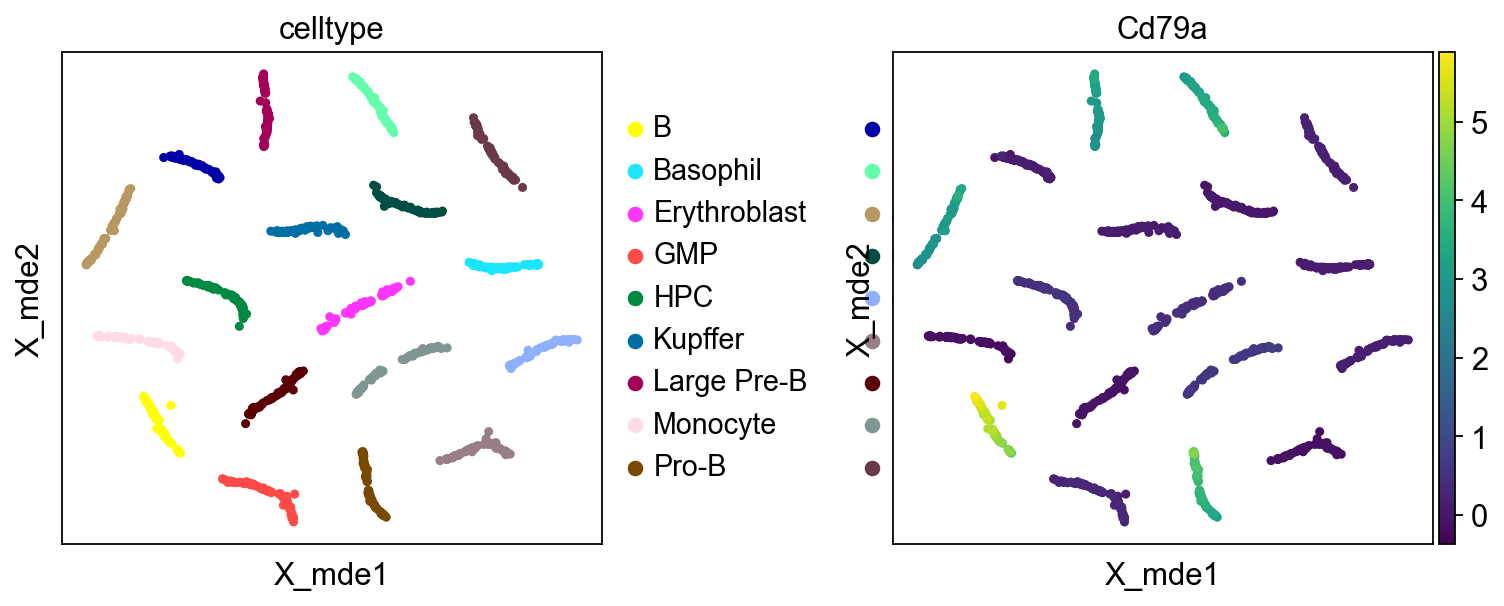

In [102]:
sc.pl.embedding(test_adata,
                basis='X_mde',
           color=['celltype','Cd79a'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

In [103]:
adata_hpc

AnnData object with n_obs × n_vars = 29370 × 18648
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lib_ID', 'lib', 'percent.mt', 'timepoint', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'timepoint_colors', 'rank_genes_groups'
    obsm: 'X_mde', 'X_mde_hpc', 'scaled|original|X_pca'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [104]:
adata_hpc.obs['celltype']=adata_hpc.obs['celltype'].copy()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


(<Figure size 480x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'Expression correlation'}, xlabel='scRNA-seq reference', ylabel='deconvoluted bulk-seq'>)

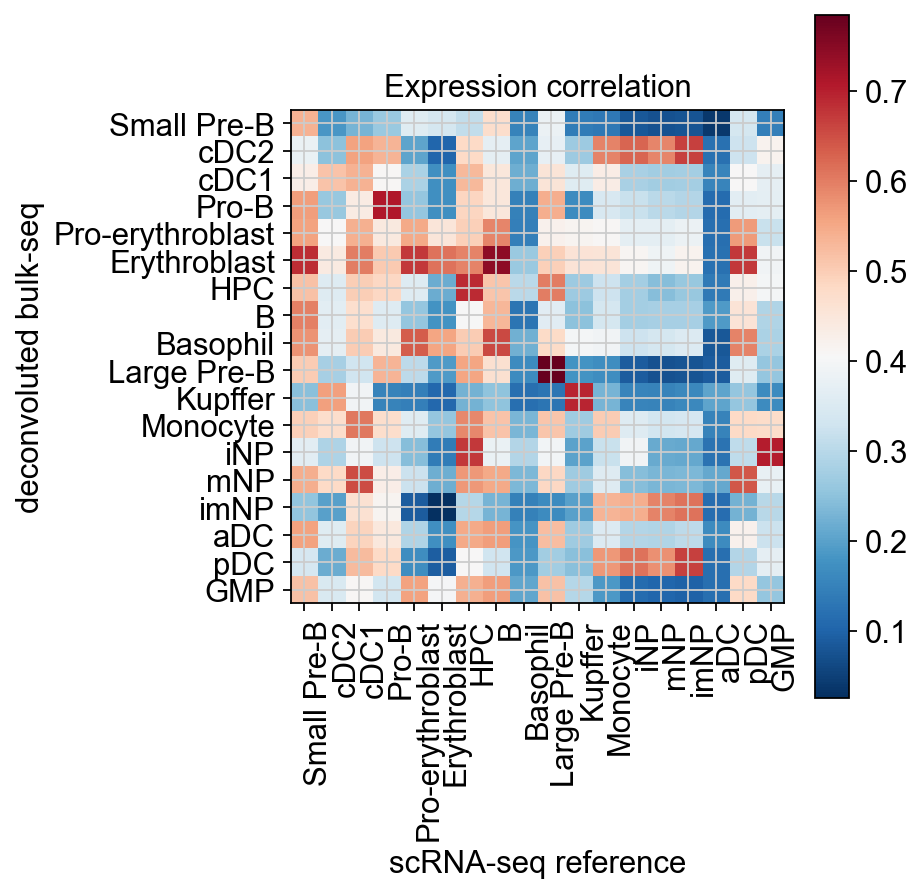

In [105]:
ov.bulk2single.bulk2single_plot_correlation(test_adata,adata_hpc,celltype_key='celltype')

In [37]:
adata_hpc.uns['log1p']['base']=None

In [106]:
cor_pd=ov.bulk2single.bulk2single_plot_correlation(adata_hpc,test_adata,celltype_key='celltype',
                                           return_table=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:30)


In [107]:
#sc.tl.rank_genes_groups(single_data, celltype_key, method='wilcoxon')
marker_df = pd.DataFrame(adata_hpc.uns['rank_genes_groups']['names']).head(200)
#marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(generate_adata.var.index.tolist()))
marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(test_adata.var.index.tolist()))

# the mean expression of 200 marker genes of input sc data
sc_marker = adata_hpc[:,marker].to_df()
sc_marker['celltype'] = adata_hpc.obs['celltype']
sc_marker_mean = sc_marker.groupby('celltype')[marker].mean()

In [108]:
sc_marker_mean=sc_marker_mean.T

In [109]:
rf_ct = list(sc_marker_mean.columns)

In [244]:
cor_pd=pd.DataFrame(cor_pd,
                   index=rf_ct,
                   columns=rf_ct)

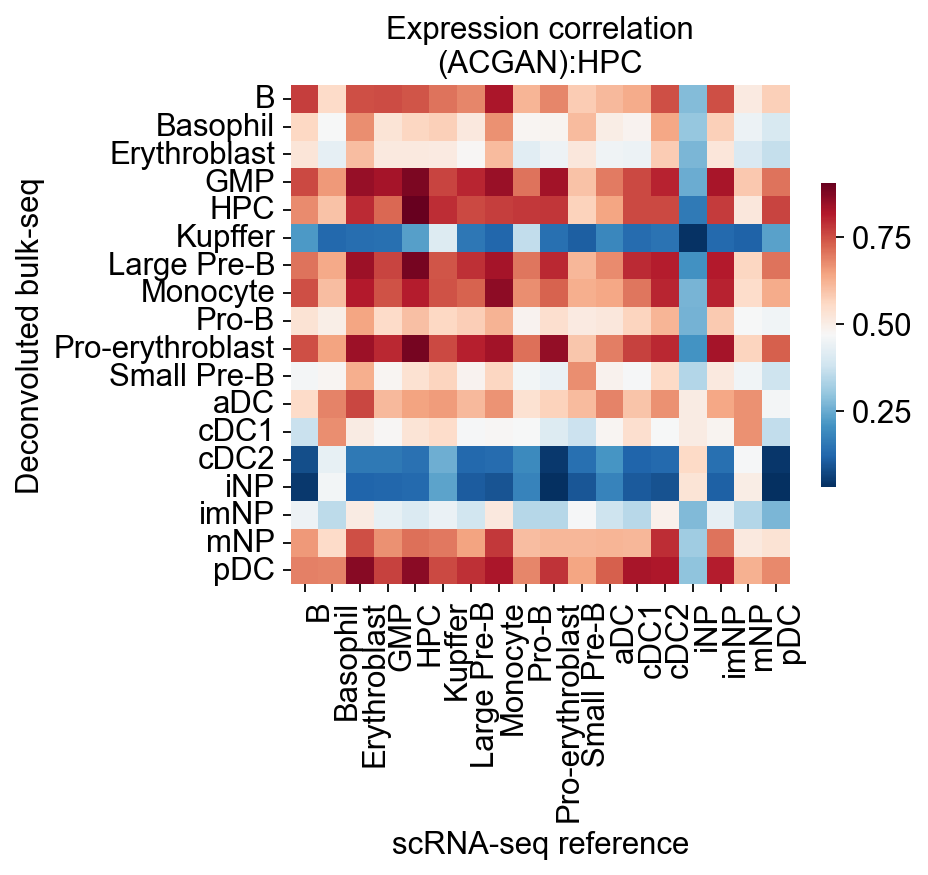

In [298]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cor_pd,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Expression correlation\n(ACGAN):HPC")
plt.savefig('figures/heatmap_expcor_acgan_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_expcor_acgan_hpc.pdf',dpi=300,bbox_inches='tight')


In [261]:
# 计算对角线均值
diagonal_mean = np.trace(cor_pd.values) / len(cor_pd)

# 计算非对角线均值
non_diagonal_mean = (np.sum(cor_pd.values) - np.trace(cor_pd.values)) / (len(cor_pd)**2 - len(cor_pd))

print("对角线均值:", diagonal_mean)
print("非对角线均值:", non_diagonal_mean)

对角线均值: 0.6200881636060933
非对角线均值: 0.5319565411795883


In [161]:
test_adata

AnnData object with n_obs × n_vars = 1800 × 13849
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'celltype_colors', 'rank_genes_groups'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [162]:
adata_hpc

AnnData object with n_obs × n_vars = 29370 × 18648
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lib_ID', 'lib', 'percent.mt', 'timepoint', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'timepoint_colors', 'rank_genes_groups'
    obsm: 'X_mde', 'X_mde_hpc', 'scaled|original|X_pca'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [181]:
cmk1=ov.single.get_celltype_marker(test_adata,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


In [184]:
adata_hpc1=ov.pp.preprocess(adata_hpc,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)

Begin robust gene identification
After filtration, 18578/18648 genes are kept. Among 18578 genes, 17425 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Igha', 'Gm26917', 'Malat1', 'S100a8', 'S100a9', 'Igkc', 'Hbb-bs', 'Camp']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [185]:
cmk2=ov.single.get_celltype_marker(adata_hpc1,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:31)


In [190]:
all_gene=[]
for clt in cmk1.keys():
    all_gene+=cmk1[clt].tolist()
for clt in cmk2.keys():
    all_gene+=cmk2[clt].tolist()
all_gene=list(set(all_gene))

In [191]:
cmk1_pd=pd.DataFrame(index=all_gene)
for clt in cmk1.keys():
    cmk1_pd[clt]=0
    cmk1_pd.loc[cmk1[clt].tolist(),clt]=1
cmk2_pd=pd.DataFrame(index=all_gene)
for clt in cmk2.keys():
    cmk2_pd[clt]=0
    cmk2_pd.loc[cmk2[clt].tolist(),clt]=1

In [225]:
cmk1={}
for clt in test_adata.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(test_adata, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk1[clt]=degs['names'][:300].tolist()

In [235]:
cmk2={}
for clt in adata_hpc1.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(adata_hpc1, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk2[clt]=degs['names'][:300].tolist()

In [236]:
all_gene=[]
for clt in cmk1.keys():
    all_gene+=cmk1[clt]
for clt in cmk2.keys():
    all_gene+=cmk2[clt]
all_gene=list(set(all_gene))

In [237]:
cmk1_pd=pd.DataFrame(index=all_gene)
for clt in cmk1.keys():
    cmk1_pd[clt]=0
    cmk1_pd.loc[cmk1[clt],clt]=1
cmk2_pd=pd.DataFrame(index=all_gene)
for clt in cmk2.keys():
    cmk2_pd[clt]=0
    cmk2_pd.loc[cmk2[clt],clt]=1

In [238]:
cmk1_pd['B'].sum()

300

In [239]:
cmk2_pd['B'].sum()

196

In [240]:
from scipy import spatial
plot_data=pd.DataFrame(index=test_adata.obs['celltype'].cat.categories,
                      columns=test_adata.obs['celltype'].cat.categories)
for clt1 in cmk1.keys():
    for clt2 in cmk1.keys():
    #print(clt,1 - spatial.distance.cosine(cmk1_pd['B'], cmk2_pd[clt]))
        plot_data.loc[clt1,clt2]=1 - spatial.distance.cosine(cmk1_pd[clt1], cmk2_pd[clt2])

In [241]:
plot_data=plot_data.astype(float)

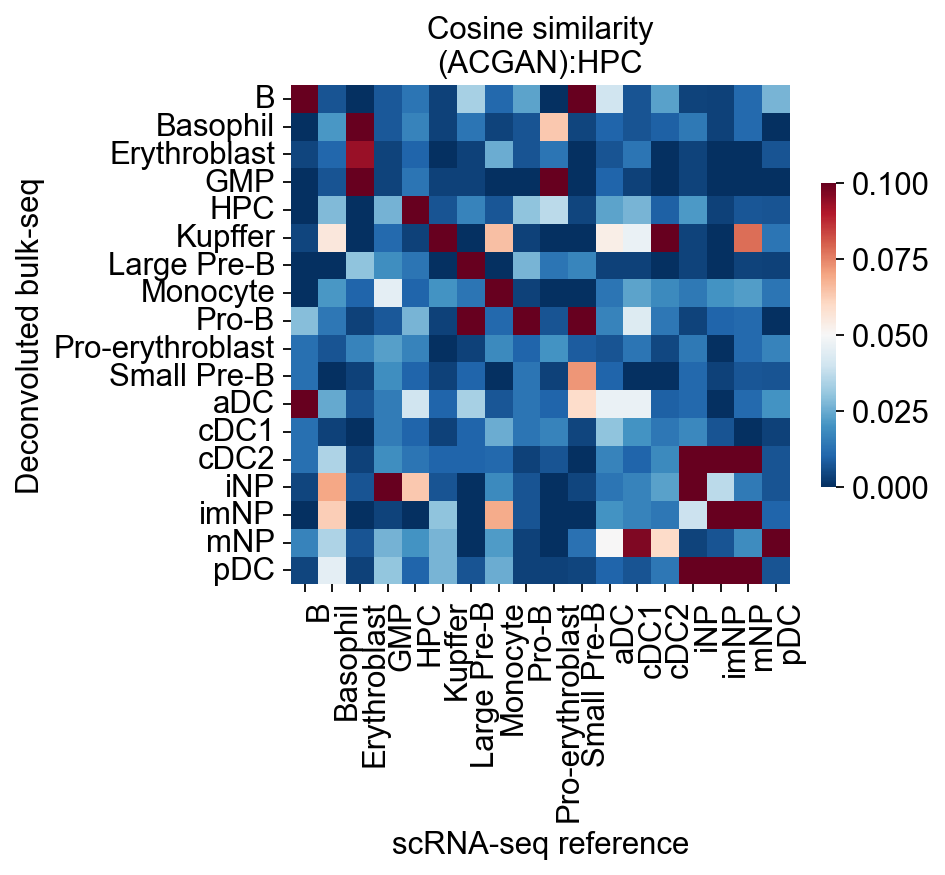

In [299]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(plot_data,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,vmax=0.1)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Cosine similarity\n(ACGAN):HPC")
plt.savefig('figures/heatmap_cossim_acgan_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_cossim_acgan_hpc.pdf',dpi=300,bbox_inches='tight')


In [262]:
# 计算对角线均值
diagonal_mean = np.trace(plot_data.values) / len(plot_data)

# 计算非对角线均值
non_diagonal_mean = (np.sum(plot_data.values) - np.trace(plot_data.values)) / (len(plot_data)**2 - len(plot_data))

print("对角线均值:", diagonal_mean)
print("非对角线均值:", non_diagonal_mean)

对角线均值: 0.1302307613513067
非对角线均值: 0.021850954138166446


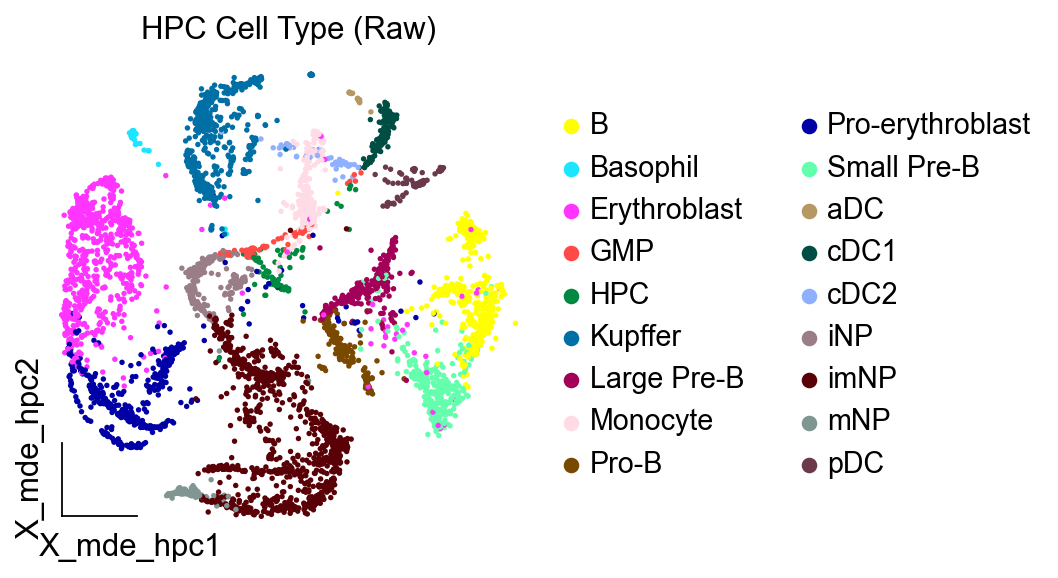

In [305]:
ov.utils.embedding(bulktb.vae_model.single_data,
                basis='X_mde_hpc',
           color=['celltype'],title='HPC Cell Type (Raw)',
                   frameon='small',show=False,
           wspace=0.4,palette=sc.pl.palettes.default_102)
plt.savefig('figures/umap_hpc_raw.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/umap_hpc_raw.pdf',dpi=300,bbox_inches='tight')


In [46]:
test_adata[test_adata.obs['celltype']=='Large Pre-B']

View of AnnData object with n_obs × n_vars = 100 × 13849
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'celltype_colors', 'rank_genes_groups'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [58]:
bulktb.vae_model.single_data.X.max()

8.476424

In [273]:
adata3=test_adata[test_adata.obs['celltype']=='Basophil']
adata3

View of AnnData object with n_obs × n_vars = 100 × 13849
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'celltype_colors', 'rank_genes_groups'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [274]:
import anndata
adata1=anndata.concat([bulktb.vae_model.single_data,adata3],
                     merge='same')
adata1

AnnData object with n_obs × n_vars = 5100 × 13849
    obs: 'celltype'
    obsm: 'scaled|original|X_pca', 'X_mde'

In [275]:
adata1.raw = adata1
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata1 = adata1[:, adata1.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [276]:
ov.pp.scale(adata1)
ov.pp.pca(adata1,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [277]:
adata1.obsm["X_mde"] = ov.utils.mde(adata1.obsm["scaled|original|X_pca"])
adata1

AnnData object with n_obs × n_vars = 5100 × 1661
    obs: 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

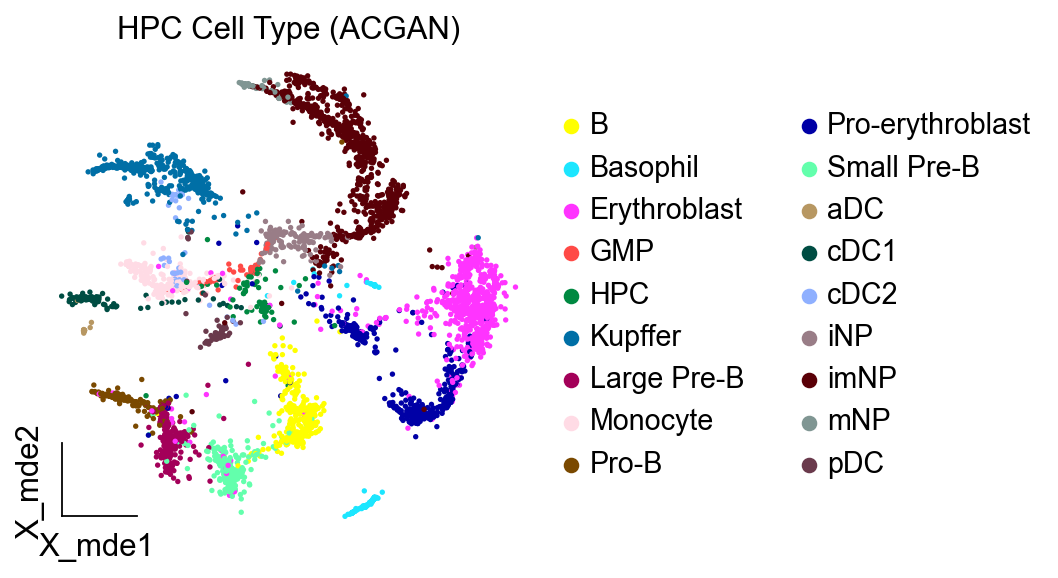

In [304]:
ov.utils.embedding(adata1,
                basis='X_mde',
           color=['celltype'],title='HPC Cell Type (ACGAN)',
                   frameon='small',show=False,
           wspace=0.4,palette=sc.pl.palettes.default_102)
plt.savefig('figures/umap_hpc_acgan.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/umap_hpc_acgan.pdf',dpi=300,bbox_inches='tight')


In [117]:
adata2=bulktb.vae_model.single_data.copy()

In [118]:
adata2.raw = adata2
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata2 = adata2[:, adata2.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [119]:
ov.pp.scale(adata2)
ov.pp.pca(adata2,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [120]:
adata2.obsm["X_mde"] = ov.utils.mde(adata2.obsm["scaled|original|X_pca"])
adata2

AnnData object with n_obs × n_vars = 5000 × 3516
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lib_ID', 'lib', 'percent.mt', 'timepoint', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'timepoint_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_mde', 'X_mde_hpc', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'connectivities', 'distances'

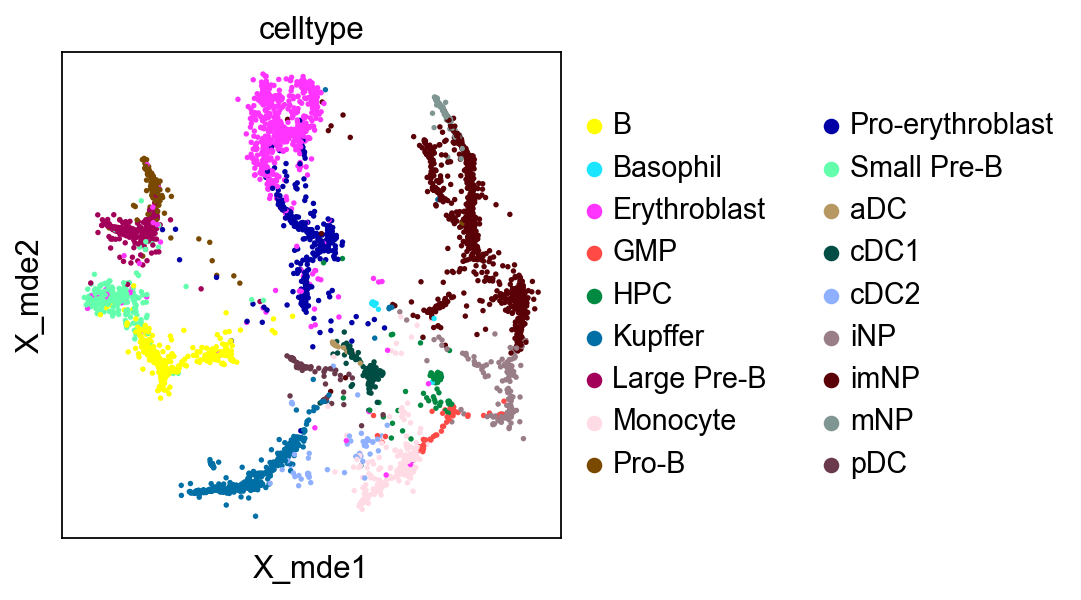

In [121]:
sc.pl.embedding(adata2,
                basis='X_mde',
           color=['celltype'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

In [123]:
opc_raw=adata2[adata2.obs['celltype'].isin(['HPC','B','Large Pre-B','Small Pre-B','Pro-B'])]
opc_raw1=adata1[adata1.obs['celltype'].isin(['HPC','B','Large Pre-B','Small Pre-B','Pro-B'])]

In [124]:
opc_raw1.obs['type']='raw'
opc_raw1.obs.loc[[i for i in opc_raw1.obs.index if '_' in i],'type']='Generate'

In [126]:
opc_raw.obsm["X_mde1"] = mde(opc_raw.obsm["scaled|original|X_pca"])
opc_raw1.obsm["X_mde1"] = mde(opc_raw1.obsm["scaled|original|X_pca"])

In [127]:
sc.pp.neighbors(opc_raw,n_neighbors=15,use_rep='scaled|original|X_pca')
sc.pp.neighbors(opc_raw1,n_neighbors=15,use_rep='scaled|original|X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


<AxesSubplot: >

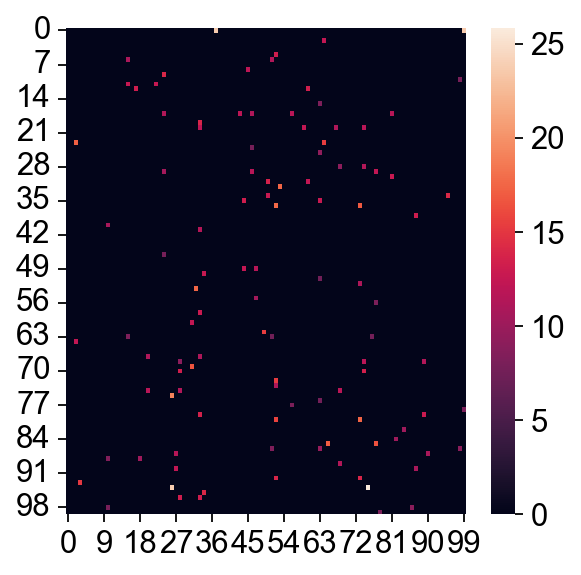

In [139]:
import seaborn as sns
sns.heatmap(opc_raw.obsp['distances'].toarray()[:100,:100])

In [141]:
cidx=opc_raw.obs.index.tolist()
cidx.reverse()

In [ ]:
sns.heatmap(opc_raw[opc_raw.obs['celltype'].isin(['Large Pre-B',
                                                 'HPC'])].obsp['distances'].toarray())

In [156]:
opc_raw[opc_raw.obs['celltype'].isin(['Large Pre-B'])].obsp['distances'].toarray().mean()

0.47783583782896866

In [157]:
test_=pd.DataFrame(opc_raw.obsp['distances'].toarray(),
                  index=opc_raw.obs.index,
                  columns=opc_raw.obs.index)
test_.head()
test_.loc[opc_raw.obs.loc[opc_raw.obs['celltype']=='Large Pre-B'].index,
         opc_raw.obs.loc[opc_raw.obs['celltype']=='HPC'].index,].values.mean()

0.0

In [158]:
test_.loc[opc_raw.obs.loc[opc_raw.obs['celltype']=='HPC'].index,
         opc_raw.obs.loc[opc_raw.obs['celltype']=='Large Pre-B'].index,].values.mean()

0.0033732333642556424

In [159]:
test_=pd.DataFrame(opc_raw1.obsp['distances'].toarray(),
                  index=opc_raw1.obs.index,
                  columns=opc_raw1.obs.index)
test_.loc[opc_raw1.obs.loc[opc_raw1.obs['celltype']=='Large Pre-B'].index,
         opc_raw1.obs.loc[opc_raw1.obs['celltype']=='HPC'].index,].values.mean()

0.00034772584895553506

In [160]:
test_=pd.DataFrame(opc_raw1.obsp['distances'].toarray(),
                  index=opc_raw1.obs.index,
                  columns=opc_raw1.obs.index)
test_.loc[opc_raw1.obs.loc[opc_raw1.obs['celltype']=='HPC'].index,
         opc_raw1.obs.loc[opc_raw1.obs['celltype']=='Large Pre-B'].index,].values.mean()

0.003608050730075451

In [263]:
v0 = ov.single.pyVIA(adata=adata2,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['HPC'],
                    dataset='group')
v0.run()

2023-10-03 19:53:10.839803	Running VIA over input data of 5000 (samples) x 50 (features)
2023-10-03 19:53:10.839847	Knngraph has 15 neighbors
2023-10-03 19:53:12.219603	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 48.4 % of edges. 
2023-10-03 19:53:12.233094	Number of connected components used for clustergraph  is 1
2023-10-03 19:53:12.299545	Commencing community detection
2023-10-03 19:53:12.529271	Finished running Leiden algorithm. Found 244 clusters.
2023-10-03 19:53:12.530341	Merging 203 very small clusters (<10)
2023-10-03 19:53:12.532407	Finished detecting communities. Found 41 communities
2023-10-03 19:53:12.532633	Making cluster graph. Global cluster graph pruning level: 0.15
2023-10-03 19:53:12.538068	Graph has 1 connected components before pruning
2023-10-03 19:53:12.539880	Graph has 4 connected components after pruning
2023-10-03 19:53:12.541804	Graph has 1 connected components after reconnecting
2023-10-03 19:53:12.542214	0.0% links tri

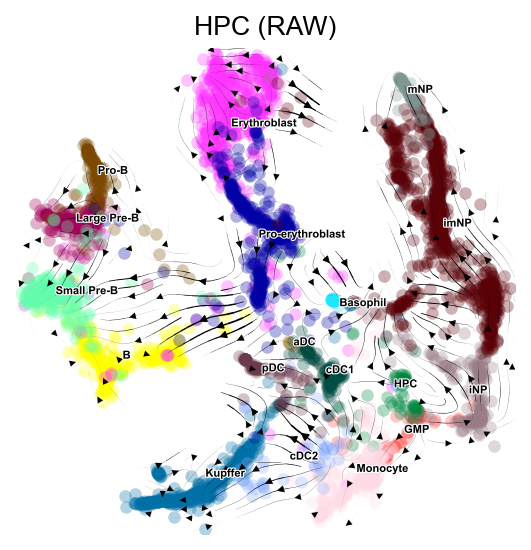

In [307]:
import matplotlib.pyplot as plt
fig,ax=v0.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('HPC (RAW)',fontsize=12)
plt.savefig('figures/via_hpc_raw.png',dpi=300,bbox_inches='tight')
#plt.savefig('pdf/via_hpc_raw.pdf',dpi=300,bbox_inches='tight')


In [265]:
v0.get_pseudotime(adata2)
sc.pp.neighbors(adata2,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata2,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [282]:
raw_transitions=pd.DataFrame(adata2.uns['paga']['transitions_confidence'].toarray(),
            index=adata2.obs['celltype'].cat.categories,
            columns=adata2.obs['celltype'].cat.categories)

In [284]:
raw_transitions.loc['Basophil','HPC']

0.018636174875056324

In [279]:
v1 = ov.single.pyVIA(adata=adata1,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['HPC'],
                     #jac_std_global=0.01,
                    dataset='group')

v1.run()

2023-10-03 19:59:55.022804	Running VIA over input data of 5100 (samples) x 50 (features)
2023-10-03 19:59:55.022849	Knngraph has 15 neighbors
2023-10-03 19:59:56.664143	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 47.5 % of edges. 
2023-10-03 19:59:56.677571	Number of connected components used for clustergraph  is 2
2023-10-03 19:59:56.744284	Commencing community detection
2023-10-03 19:59:56.978274	Finished running Leiden algorithm. Found 261 clusters.
2023-10-03 19:59:56.979451	Merging 222 very small clusters (<10)
2023-10-03 19:59:56.981395	Finished detecting communities. Found 39 communities
2023-10-03 19:59:56.981621	Making cluster graph. Global cluster graph pruning level: 0.15
2023-10-03 19:59:56.987431	Graph has 2 connected components before pruning
2023-10-03 19:59:56.989095	Graph has 5 connected components after pruning
2023-10-03 19:59:56.990998	Graph has 2 connected components after reconnecting
2023-10-03 19:59:56.991394	0.0% links tri

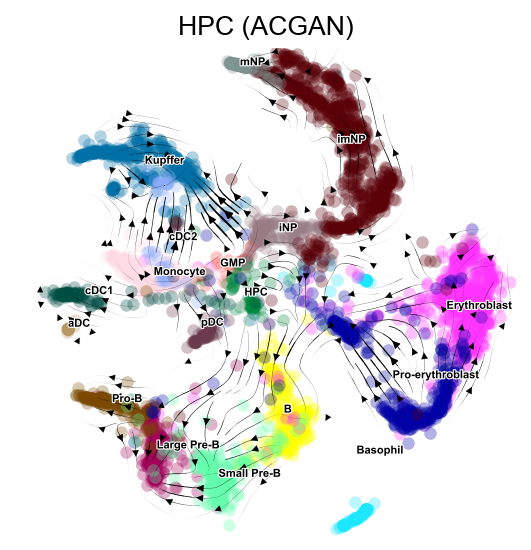

In [308]:
import matplotlib.pyplot as plt
fig,ax=v1.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
#plt.title('After HPC',fontsize=12)
plt.title('HPC (ACGAN)',fontsize=12)
plt.savefig('figures/via_hpc_acgan.png',dpi=300,bbox_inches='tight')

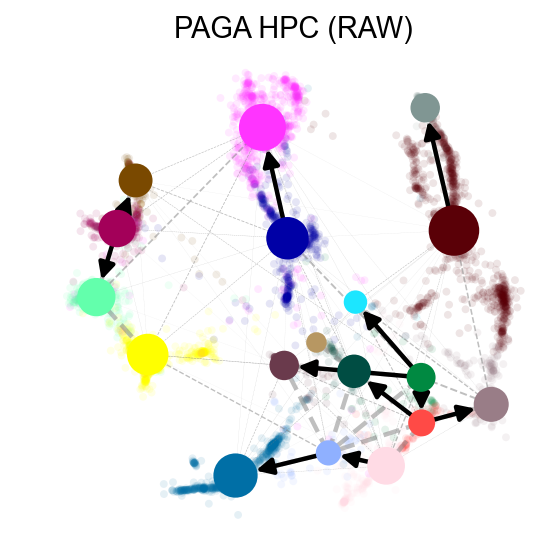

In [312]:
ov.utils.plot_paga(adata2,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)
plt.title('PAGA HPC (RAW)',fontsize=13)
plt.savefig('figures/paga_hpc_raw.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/paga_hpc_raw.pdf',dpi=300,bbox_inches='tight')

In [286]:
v1.get_pseudotime(adata1)
sc.pp.neighbors(adata1,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata1,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [287]:
after_transitions=pd.DataFrame(adata1.uns['paga']['transitions_confidence'].toarray(),
            index=adata1.obs['celltype'].cat.categories,
            columns=adata1.obs['celltype'].cat.categories)

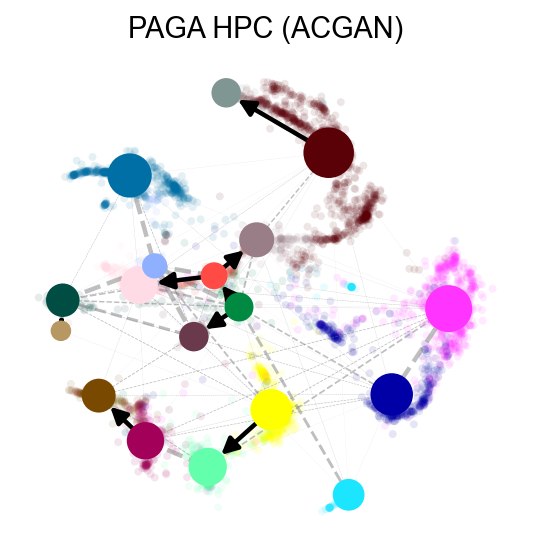

In [311]:
ov.utils.plot_paga(adata1,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)
plt.title('PAGA HPC (ACGAN)',fontsize=13)
plt.savefig('figures/paga_hpc_acgan.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/paga_hpc_acgan.pdf',dpi=300,bbox_inches='tight')

(0.0, 1.0)

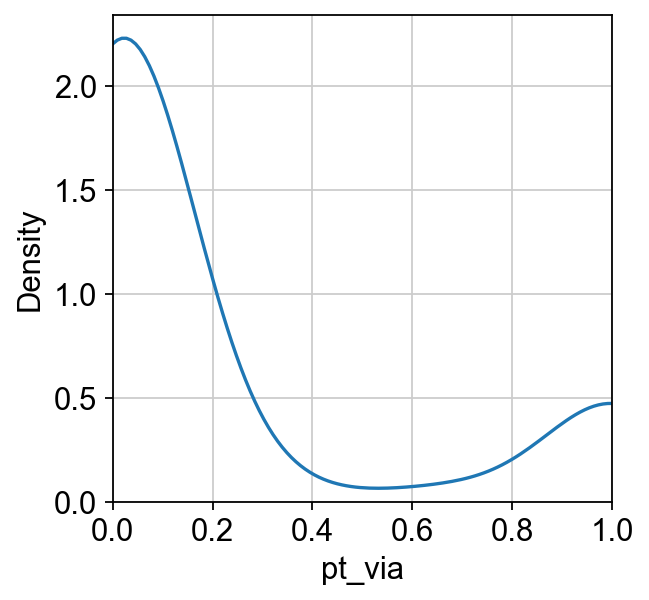

In [289]:
import seaborn as sns
sns.kdeplot(adata1.obs.loc[adata1.obs['celltype']=='Basophil'],x='pt_via')
plt.xlim(0,1)

In [291]:
np.var(adata1.obs.loc[adata1.obs['celltype']=='Basophil','pt_via'])

0.13445059594126832

(0.0, 1.0)

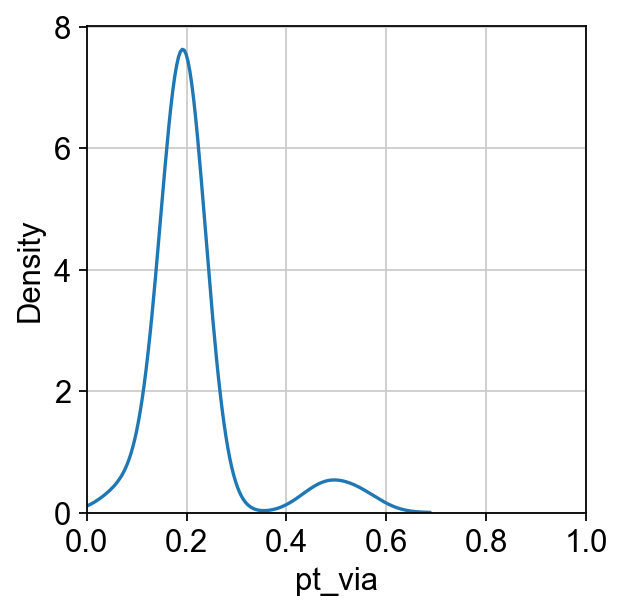

In [290]:
import seaborn as sns
sns.kdeplot(adata2.obs.loc[adata2.obs['celltype']=='Basophil'],x='pt_via')
plt.xlim(0,1)

In [292]:
np.var(adata2.obs.loc[adata2.obs['celltype']=='Basophil','pt_via'])

0.008367327910538782

In [293]:
res_dict={}

#Cor:exp
# 计算对角线均值
diagonal_mean = np.trace(cor_pd.values) / len(cor_pd)
# 计算非对角线均值
non_diagonal_mean = (np.sum(cor_pd.values) - np.trace(cor_pd.values)) / (len(cor_pd)**2 - len(cor_pd))

res_dict['Cor_mean']=diagonal_mean
res_dict['non_Cor_mean']=non_diagonal_mean

#Cos:gene
# 计算对角线均值
diagonal_mean = np.trace(plot_data.values) / len(plot_data)

# 计算非对角线均值
non_diagonal_mean = (np.sum(plot_data.values) - np.trace(plot_data.values)) / (len(plot_data)**2 - len(plot_data))

res_dict['Cos_mean']=diagonal_mean
res_dict['non_Cos_mean']=non_diagonal_mean

#raw:trans
res_dict['Trans_raw']=raw_transitions.loc['Basophil'].max()
res_dict['Trans_after']=after_transitions.loc['Basophil'].max()


#Variance
res_dict['Var_raw']=np.var(adata2.obs.loc[adata2.obs['celltype']=='Basophil','pt_via'])
res_dict['Var_after']=np.var(adata1.obs.loc[adata1.obs['celltype']=='Basophil','pt_via'])


In [294]:
res_dict

{'Cor_mean': 0.6200881636060933,
 'non_Cor_mean': 0.5319565411795883,
 'Cos_mean': 0.1302307613513067,
 'non_Cos_mean': 0.021850954138166446,
 'Trans_raw': 0.018636174875056324,
 'Trans_after': 0.0,
 'Var_raw': 0.008367327910538782,
 'Var_after': 0.13445059594126832}

In [295]:
import pickle
with open('result/metric_acgan_hpc.pkl','wb') as f:
    pickle.dump(res_dict,f)

In [ ]:
with open('result/metric_acgan_hpc.pkl','rb') as f:
    res_dict=pickle.load(f)
res_dict